# VM환경 너무 갑갑해서 로컬 환경에서 돌려보려고 작성
- Azure에서 제공받은 VM환경이 인터넷 상태가 좋지 않은지 돌아가는 게 시원찮아서 로컬 환경에서 천천히 하나씩 보고 돌려보려고 주피터 노트북으로 작성해보았습니다.
- 저장된 로컬 파일은 .py script 파일들로 돌려도 동일한 결과가 나왔기에 생략하였습니다.

In [2]:
import random
import torch
import os
import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageFilter
import torch.nn as nn
from torch.utils.data import DataLoader
from custom_dataset import custom_dataset
from torchvision import models
import timm
from timm.loss import LabelSmoothingCrossEntropy

In [5]:
class custom_dataset(Dataset) :

    def __init__(self, file_path):
        # file_path -> data/train   /0/*.png
        self.file_path = glob.glob(os.path.join(file_path,"*","*.png" ))
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
    def __getitem__(self, item):

        image_path = self.file_path[item]
        label = image_path.split("\\")
        # print(label)
        label = int(label[1])

        mo =  image_path.split("\\")
        mo = mo[0]

        img = Image.open(image_path).convert('RGB')

        if mo == "data/train" :
            pass
            if random.uniform(0,1) < 0.2 or img.getbands()[0] == 'L' :
                # Random gray scale from 20%
                img = img.convert('L').convert("RGB")

            if random.uniform(0,1) < 0.2 :
                # Rnadom Gaussian blur from 20%
                gaussianBlur = ImageFilter.GaussianBlur(random.uniform(0.5, 1.2))
                img = img.filter(gaussianBlur)

        else :
            if img.getbands()[0] == 'L' :
                img = img.convert('L').convert('RGB')
        img = self.transform(img)
        # print(img.size(), image_path)

        return img, label

    def __len__(self):
        return  len(self.file_path)

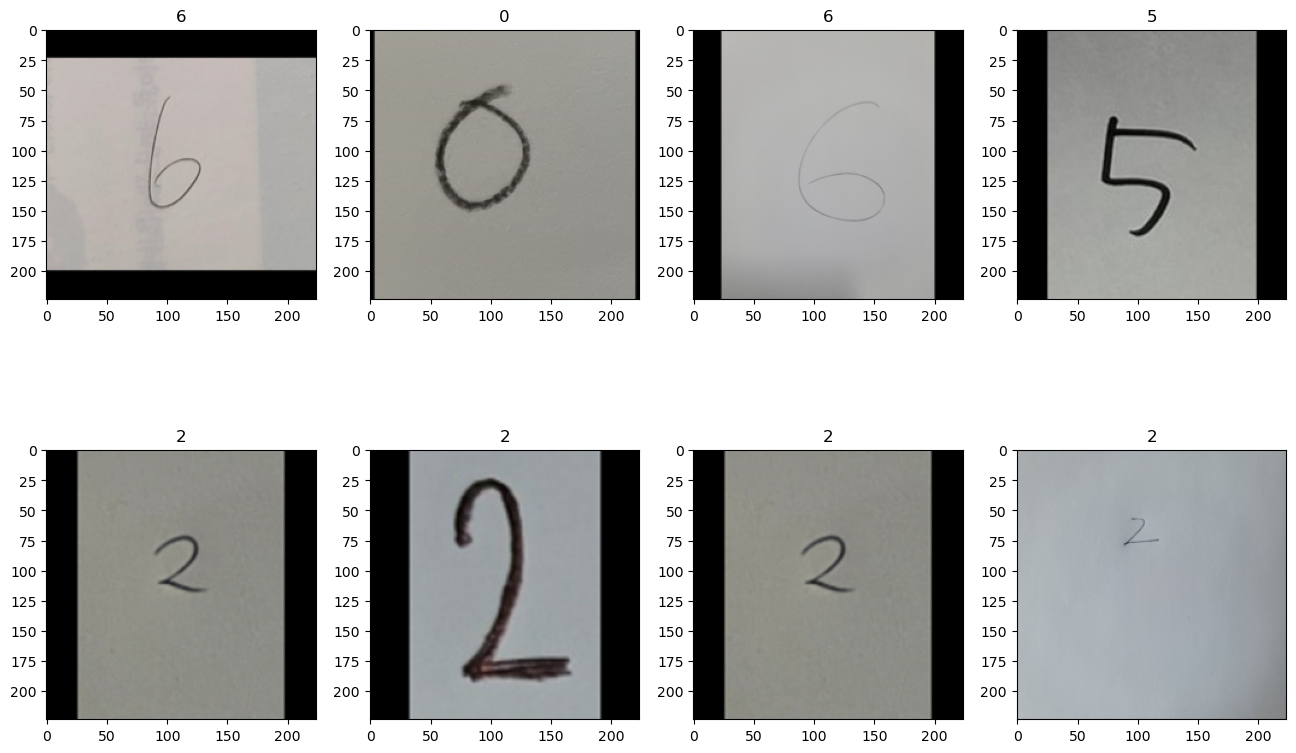

In [6]:
train_dataset = custom_dataset("./data/train")
for i in train_dataset :
    pass

# print(train_dataset.__len__())

_ , ax = plt.subplots(2,4,figsize=(16,10))

for i in range(8) :
    data = train_dataset.__getitem__(np.random.choice(range(train_dataset.__len__())))

    image = data[0].cpu().detach().numpy().transpose(1,2,0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(label)

plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# dataset
train_data = custom_dataset("./data/train")
test_data  = custom_dataset("./data/train")

# dataloader
train_loader = DataLoader(train_data,batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)

In [9]:
# model call
net = models.__dict__["resnet18"](pretrained=True)
net.fc = nn.Linear(512,10)
net.to(device)

# loss function
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device) # this is better than nn.CrossEntropyLoss
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

In [10]:
net.train()
total_step = len(train_loader)
curr_lr = 0.001
best_score = 0
num_epochs = 100
for epoch in range(num_epochs + 1) :
    total_loss = 0
    for i,(images, labels) in enumerate(train_loader) :
        images = images.to(device)
        labels = labels.to(device)
        output = net(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0 :
            print("{} / {}".format(12*(i+1), train_data.__len__()))

    net.eval()
    score = 0
    total = 0
    for i,(images, labels) in enumerate(test_loader) :
        images = images.to(device)
        labels = labels.to(device)
        output = net(images)

        total += images.size(0)
        _, argmax = torch.max(output, 1)
        score += (labels == argmax).sum().item()
    print("Epoch : {}, Loss : {:.4f}".format(
        epoch+1, total_loss / total_step
    ))

    avg = (score / total * 100)
    print("Accuracy : {:.2f}\n".format(avg))
    net.train()

    if best_score < avg :
        best_score = avg
        torch.save(net.state_dict(), "./best.pt")

c:\ProgramData\Anaconda3\envs\envuntil2022-12-15\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch : 1, Loss : 1.5014
Accuracy : 80.78

Epoch : 2, Loss : 0.9126
Accuracy : 92.06

Epoch : 3, Loss : 0.6930
Accuracy : 95.06

Epoch : 4, Loss : 0.6793
Accuracy : 98.24

Epoch : 5, Loss : 0.6606
Accuracy : 99.47

Epoch : 6, Loss : 0.6720
Accuracy : 100.00

Epoch : 7, Loss : 0.6224
Accuracy : 100.00

Epoch : 8, Loss : 0.5965
Accuracy : 99.82

Epoch : 9, Loss : 0.5869
Accuracy : 99.65

Epoch : 10, Loss : 0.5658
Accuracy : 100.00

Epoch : 11, Loss : 0.5523
Accuracy : 100.00

Epoch : 12, Loss : 0.5290
Accuracy : 100.00

Epoch : 13, Loss : 0.5340
Accuracy : 100.00

Epoch : 14, Loss : 0.5265
Accuracy : 100.00

Epoch : 15, Loss : 0.5311
Accuracy : 100.00

Epoch : 16, Loss : 0.5298
Accuracy : 100.00

Epoch : 17, Loss : 0.5225
Accuracy : 100.00

Epoch : 18, Loss : 0.5269
Accuracy : 100.00

Epoch : 19, Loss : 0.5841
Accuracy : 100.00

Epoch : 20, Loss : 0.5497
Accuracy : 100.00

Epoch : 21, Loss : 0.5281
Accuracy : 100.00

Epoch : 22, Loss : 0.5234
Accuracy : 100.00

Epoch : 23, Loss : 0.5178
